# Full example

In [1]:
push!(LOAD_PATH,"C:/JMB/DINEOF.jl/src","."); using DINEOF
using PyPlot
using LinearAlgebra
using Arpack
using Statistics
using Optim
using NCDatasets
using FTPClient

┌ Info: Recompiling stale cache file C:\Users\jmbeckers\.julia\compiled\v1.2\DINEOF.ji for DINEOF [top-level]
└ @ Base loading.jl:1240


## Get a nice data cube and look at it

In [2]:
fname="c:/Users/JMBECKERS/Downloads/SPMCT.nc"


"c:/Users/JMBECKERS/Downloads/SPMCT.nc"

In [3]:
ds=Dataset(fname)

Dataset: c:\Users\JMBECKERS\Downloads\SPMCT.nc
Group: /

Dimensions
   time = 366
   lat = 124
   lon = 115

Variables
  time   (366)
    Datatype:    Float64
    Dimensions:  time
    Attributes:
     units                = seconds since 1970-1-1
     calendar             = gregorian
     standard_name        = time

  coverage   (366)
    Datatype:    Float64
    Dimensions:  time
    Attributes:
     long_name            = Percentage of valid pixels
     valid_min            = 0.0
     valid_max            = 100.0

  lat   (124)
    Datatype:    Float64
    Dimensions:  lat
    Attributes:
     units                = degrees north
     standard_name        = latitude

  lon   (115)
    Datatype:    Float64
    Dimensions:  lon
    Attributes:
     units                = degrees east
     standard_name        = longitude

  spm   (115 × 124 × 366)
    Datatype:    Float64
    Dimensions:  lon × lat × time
    Attributes:
     _FillValue           = -999.0
     units                = 

In [4]:
spm=ds["spm"][:]
spm[ismissing.(spm)].=NaN

3495799-element view(reshape(::Array{Union{Missing, Float64},3}, 5219160), [1, 57, 58, 59, 60, 61, 62, 63, 75, 116  …  5219151, 5219152, 5219153, 5219154, 5219155, 5219156, 5219157, 5219158, 5219159, 5219160]) with eltype Union{Missing, Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [5]:
meanspm=mean(spm[.!isnan.(spm)])

4.483804048101992

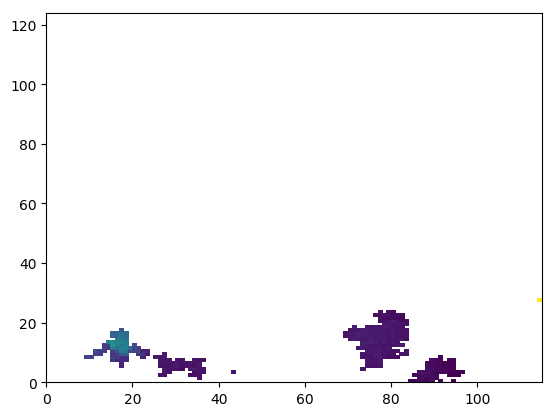

PyObject <matplotlib.collections.PolyCollection object at 0x0000000035D33630>

In [6]:
pcolor(spm[:,:,10]')

## Make a first analysis with only a limited number of EOFs

In [ ]:
@time offset,XA,U,S,V,cvEOF,cvarray,errmap,musquare=DINEOFrun(spm,[1,1,2];eofmax=10)
@show S,sum(S),offset

pcolor(U[4][1]),colorbar()
figure()
plot(V[4][1])

Raw data variance and mean: 44.369489491157815 and 4.483804048101992
Number of missing points (including possible masks): 3495799 out of 5219160
Number of data points before elimination of low coverage regions is 1723361 and cv fraction 0.010205058603507913
Number of data points after elimination of low coverage regions is 1655503 and cv fraction 0.010183007823000018


In [ ]:
@time offset,XA,U,S,V,cvEOF,cvarray,errmap,musquare=DINEOFrun(spm,[1,2,1];eofmax=10)
@show S,sum(S),offset

pcolor(U[4][1]),colorbar()
figure()
plot(V[4][1])

In [ ]:
@time offset,XA,U,S,V,cvEOF,cvarray,errmap,musquare=DINEOFrun(spm,[2,1,1];eofmax=10)
@show S,sum(S),offset

pcolor(U[4][1]),colorbar()
figure()
plot(V[4][1])

## Decide which directions to collapse and make a full analysis

In this example the classical space time decomposition seems to work. So lets try and add a time filter onto it with cross-validation by clouds.



In [ ]:
@time offset,XA,U,S,V,cvEOF,cvarray,errmap,musquare=DINEOFrun(spm,[1,1,2];minimumcoverage=[0.05,0.01],filter="vpmf",filterrepetitions=3,cvmethod="CopyMask")
@show S,sum(S),offset

pcolor(U[4][1]),colorbar()
figure()
plot(V[4][1])

## Apply QC and take out suspect points (put NaN)

In [ ]:
OO=DINEOF_pmQC(spm,XA.+offset,errmap,musquare,4)
@show mean(OO[.!isnan.(OO)])
pcolor(OO[:,:,1]),colorbar()
figure()
pcolor(spm[:,:,1]),colorbar()

In [ ]:
sum(OO.>5)/sum(.!isnan.(spm))*100

## Redo the decomposition but by restarting

With a time filter you can accept possibly empty images (so coverage for fixed time can be zero

In [ ]:
sum(isnan.(XA))

In [ ]:
prod(size(XA))

In [ ]:
spmf=deepcopy(spm)
spmf[OO.>5].=NaN
@show sum(isnan.(spmf)),sum(isnan.(spm))
@time offset,XA,U,S,V,cvEOF,cvarray,errmap,musquare=DINEOFrun(spmf,[1,1,2];restart=XA.+offset,eofstart=size(S)[1]-3,minimumcoverage=[0.05,0.00],filter="vpmf",filterrepetitions=3,cvmethod="CopyMask")
@show S,sum(S),offset

In [ ]:
pcolor(U[2][1]),colorbar()
figure()
plot(V[1][1])

## Look at error field

In [ ]:
pcolor(errmap[:,:,303]),colorbar()
figure()
pcolor(spm[:,:,303]),colorbar()



## Fuse the original data and the reconstruction to look at the effect

In [ ]:
pcolor(XA[:,:,303]),colorbar()

In [ ]:
pcolor(spm[:,:,304]),colorbar()

In [ ]:
pcolor(spmf[:,:,304]),colorbar()

In [ ]:
DINEOF_fuse!(spmf,XA,4)

In [ ]:
pcolor(spmf[:,:,304]),colorbar()